In [15]:
#Import
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,EfficientNetB0, EfficientNetV2B2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
import os
import matplotlib.pyplot as plt

In [16]:
def augment_and_resize_dataset(base_path, img_size=(150, 150), batch_size=32):
    train_path = os.path.join(base_path, 'train')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Hanya rescale untuk data test
    test_datagen = ImageDataGenerator(rescale=1./255)


    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, test_generator

# Path ke folder utama
base_path = "dataset_cadangan/"

train_generator, test_generator = augment_and_resize_dataset(base_path)

Found 2433 images belonging to 4 classes.
Found 738 images belonging to 4 classes.


In [17]:
class_indices = train_generator.class_indices
print(class_indices)

{'Apple_scab': 0, 'Black_rot': 1, 'Cedar_apple_rust': 2, 'healthy': 3}


MobileNet

In [18]:
# pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150,150,3))

# for layer in pre_trained_model.layers:
#     layer.trainable = False

# model = Sequential()

# model.add(pre_trained_model)

# # Menambahkan Conv2D and Pooling layers
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten(name="flatten"))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation="relu"))
# model.add(Dense(4, activation='softmax'))

EfficientNet V1

In [19]:
# pre_trained_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# for layer in pre_trained_model.layers:
#     layer.trainable = False

# model = Sequential()

# model.add(pre_trained_model)

# # Menambahkan Conv2D and Pooling layers
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten(name="flatten"))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation="relu"))
# model.add(Dense(4, activation='softmax'))

EfficientNet V2

In [20]:
pre_trained_model = EfficientNetV2B2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

for layer in pre_trained_model.layers:
    layer.trainable = False

model = Sequential()

model.add(pre_trained_model)

# Menambahkan Conv2D and Pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten(name="flatten"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dense(4, activation='softmax'))

35839040/35839040 [==============================] - 13s 0us/step


In [21]:
#Melakukan compile model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [22]:
# Compile model
optimizer = tf.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, restore_best_weights=True, mode='max', baseline=0.96)

In [24]:
# Melatih model
num_epochs = 15

H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=test_generator,
              callbacks=[checkpoint, early_stopping],
              verbose=1)

Epoch 1/15
77/77 [==============================] - 76s 831ms/step - loss: 1.2600 - accuracy: 0.4871 - val_loss: 1.2593 - val_accuracy: 0.5176
Epoch 2/15
77/77 [==============================] - 58s 756ms/step - loss: 1.2312 - accuracy: 0.5162 - val_loss: 1.1971 - val_accuracy: 0.5176
Epoch 3/15
77/77 [==============================] - ETA: 0s - loss: 1.2181 - accuracy: 0.5191

In [ ]:
# MobileNetV2
# 57/57 [==============================] - 91s 2s/step - loss: 0.4142 - accuracy: 0.8611 - val_loss: 0.8843 - val_accuracy: 0.7342

In [ ]:
# EfficientNetV2B0
# 77/77 [==============================] - 47s 606ms/step - loss: 1.1946 - accuracy: 0.5191 - val_loss: 1.1941 - val_accuracy: 0.5176

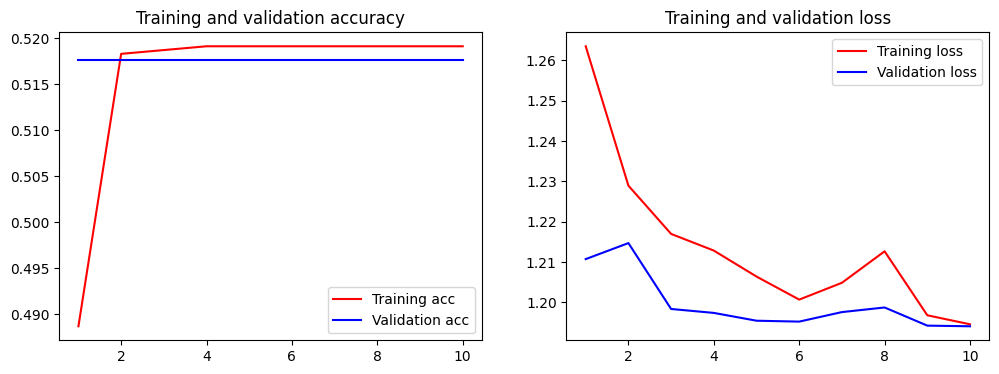

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(H)